In [2]:
import sys
sys.path.append('scripts/')
from mcl import *
from kf import * 

初期状態では、まだ観測を行っていないので、分散共分散行列はNone, ランドーマークの位置は$(0,0)$にしておく。

$\Sigma = None$

$\hat { \boldsymbol { m } } = \left( \begin{array} { c } { m _ { x } } \\ { m _ { y } } \end{array} \right) = \left( \begin{array} { c } { 0 } \\ { 0 } \end{array} \right)$

In [15]:
class MapParticle(Particle):  
    def __init__(self, init_pose, weight, landmark_num):
        super().__init__(init_pose, weight)
        self.map = Map()
        
        for i in range(landmark_num):
            self.map.append_landmark(EstimatedLandmark())
    
    # 観測を行って、ランドマークの情報を更新するには、前の時刻のランドマーク情報が必要となる。
    # しかし、初めて観測するランドマークには前の時刻のランドマークに関する情報が存在しないため、
    # 観測情報からランドマークの情報を初期化する必要がある。
    # このランドーマークの情報は、ガウス分布の情報となっている。
    def init_landmark_estimation(self, landmark, z, distance_dev_rate, direction_dev):
        # 値をコピー
        x, y, t = self.pose
        ell, phi = z
        
        # ランドマークを観測した際、ロボットから見たランドーマークの位置が極座標の情報として得られる。
        # この観測情報は、極座標系の値なので、地図上の座標で表すために直交座標系に変換する。
        # しかし、観測方程式h(m)はatan2を含んでいるため非線形である。
        mx, my = ell*math.cos(t + phi) + x, ell*math.sin(t + phi) + y
        
        # 観測方程式が非線形の場合、ガウス分布である保証がないので、テイラー展開を用いて、観測方程式を線形に近似する。
        # 線形に近似すると、以下のようなテイラー級数h(m)とHの式になる。
        # Hはmまわりで偏微分したヤコビ行列である。
        H = np.array([[(mx - x)/math.sqrt(ell), (my - y)/math.sqrt(ell)], 
                                [                     (y - my)/ell,                   (mx - x)/ell]])
        
        # 分散共分散行列Qを事前に与えたランドマークを観測する際に生じる誤差の標準偏差から計算する。
        # distance_dev_rateは、距離に応じて、標準偏差が大きくなるようにする係数である。
        Q = np.diag(np.array([(distance_dev_rate*ell)**2, direction_dev**2]))
        
        # 上記で求めたQとHを使って、分散共分散行列を求める。
        landmark.cov = np.linalg.inv(H.T.dot( np.linalg.inv(Q) ).dot(H))
        # ランドマークを観測した際に求めたmx, my
        landmark.pos = np.array([mx, my]).T
        
    def observation_update_landmark(self, landmark, z, distance_dev_rate, direction_dev):  ###fastslam7
        # 値をコピー
        x, y, _ = self.pose
        mx, my =  landmark.pos
        
        # 自身の位置(self.pose), ランドマークの位置(landmark.pos)で、ロボットから見たランドマークの距離と方角を取得する。
        estm_z = IdealCamera.relative_polar_pos(self.pose, landmark.pos)
        estm_ell, _ = estm_z
        if estm_ell < 0.01:
            return
        
        # init_landmark_estimationのHと同様に、観測方程式が非線形の場合、
        # ガウス分布である保証がないので、テイラー展開を用いて、観測方程式を線形に近似する。
        # 線形に近似すると、以下のようなテイラー級数h(m)とHの式になる。
        # Hはmまわりで偏微分したヤコビ行列である。
        H = np.array([[(mx - x)/math.sqrt(estm_ell), (my - y)/math.sqrt(estm_ell)],  [(y - my)/estm_ell, (mx - x)/estm_ell]])
        
        # init_landmark_estimationのHと同様に、分散共分散行列Qを事前に与えたランドマークを観測する際に生じる誤差の標準偏差から計算する。
        # distance_dev_rateは、距離に応じて、標準偏差が大きくなるようにする係数である。
        Q = np.diag(np.array([(distance_dev_rate*estm_ell)**2, direction_dev**2]))
        
        # Kはカルマンゲインで呼ばれるものであり、得られた観測情報を前の時刻に推定したランドマークに対して、どの程度反映するかのゲインである。
        K = landmark.cov.dot(H.T).dot( np.linalg.inv(Q + H.dot(landmark.cov).dot(H.T)) )
        
        ###重みの更新###
        # ここでは、パーティクルの重みの更新を行う.
        # 重みの更新には、ガウス分布の確率密度関数を尤度としているが、尤度の計算を行う前に、観測結果から得られたQ, Hをランドマークの情報に反映しておく。
        Q_z = H.dot(landmark.cov).dot(H.T) + Q
         # この尤度関数は、ガウス分布なので、平均(中心)に近いほど尤度が高くなる。
        self.weight *= multivariate_normal(mean=estm_z, cov=Q_z).pdf(z)
        
        ###ランドマークの推定の更新###
        # カルマンゲインKから、ランドマークのガウス分布を更新
        landmark.pos = K.dot(z - estm_z) + landmark.pos
        landmark.cov = (np.eye(2) - K.dot(H)).dot(landmark.cov)
        
    def observation_update(self, observation, distance_dev_rate, direction_dev):
        for d in observation:
            z = d[0]
            landmark = self.map.landmarks[d[1]]
            
            if landmark.cov is None:
                self.init_landmark_estimation(landmark, z, distance_dev_rate, direction_dev)
            else:
                self.observation_update_landmark(landmark, z, distance_dev_rate, direction_dev)

In [16]:
# 推定されたランドマークのクラス
class EstimatedLandmark(Landmark):
    def __init__(self):
        super().__init__(0,0)
        self.cov = None #変更
        
    def draw(self, ax, elems): 
        if self.cov is None:
            return
        
        ###推定位置に青い星を描く###
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="blue")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))
        
        ###誤差楕円を描く###
        e = sigma_ellipse(self.pos, self.cov, 10)
        elems.append(ax.add_patch(e))

In [17]:
class FastSlam(Mcl):
    def __init__(self, particle_num, init_pose, landmark_num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05):
        super().__init__(None, init_pose, particle_num, motion_noise_stds, distance_dev_rate, direction_dev)
        
        self.particles = [MapParticle(init_pose, 1.0/particle_num, landmark_num) for i in range(particle_num)]
        self.ml = self.particles[0]
    
    def observation_update(self, observation):  
        for p in self.particles:
            p.observation_update(observation, self.distance_dev_rate, self.direction_dev) #self.mapを削除
        self.set_ml()
        # リサンプリング
        self.resampling() 
        
    def draw(self, ax, elems):
        super().draw(ax, elems)
        self.ml.map.draw(ax, elems)

<IPython.core.display.Javascript object>


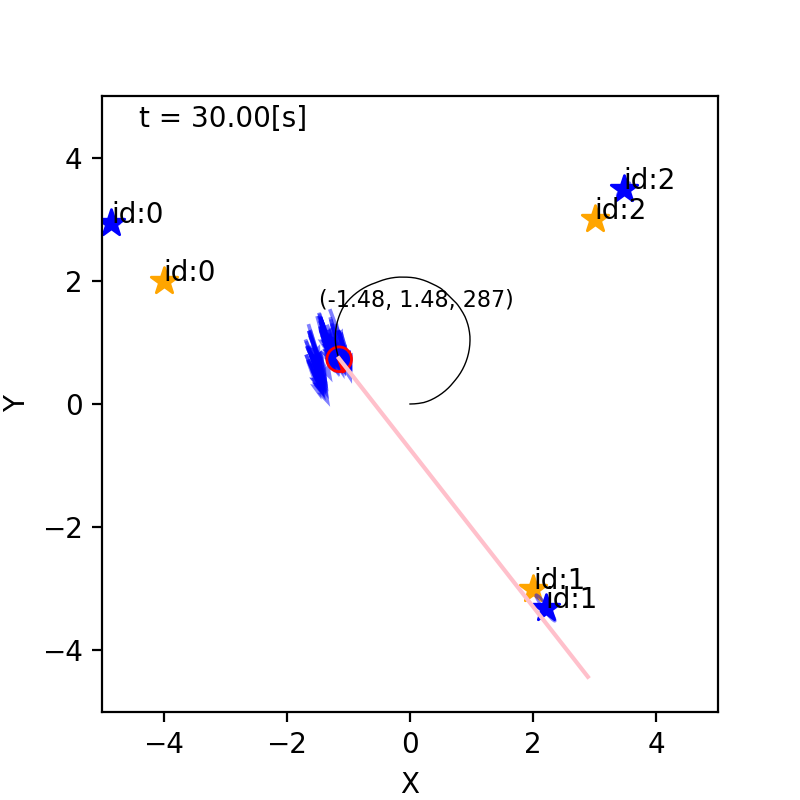

In [18]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval) 

    ###真の地図を作成###
    m = Map()
    landmark_positions = [(-4,2), (2,-3), (3,3)]
    for p in landmark_positions:
        m.append_landmark(Landmark(*p))
        
    world.append(m)       #ここより上は省略

    ### ロボットを作る ###
    init_pose = np.array([0,0,0]).T
    pf = FastSlam(100, init_pose, len(m.landmarks))
    a = MclAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()

In [6]:
a.pf.particles[10].map.landmarks[2].cov

In [7]:
math.sqrt(0.0025)

0.05